# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Основные шаги:

1. Загрузите данные, путь к файлу: /datasets/autos.csv.

2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.

3. Подготовьте выборки для обучения моделей.

4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.

5. Проанализируйте время обучения, время предсказания и качество моделей.

6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Признаки:

• DateCrawled — дата скачивания анкеты из базы

• VehicleType — тип автомобильного кузова

• RegistrationYear — год регистрации автомобиля

• Gearbox — тип коробки передач

• Power — мощность (л. с.)

• Model — модель автомобиля

• Kilometer — пробег (км)

• RegistrationMonth — месяц регистрации автомобиля

• FuelType — тип топлива

• Brand — марка автомобиля

• Repaired — была машина в ремонте или нет

• DateCreated — дата создания анкеты

• NumberOfPictures — количество фотографий автомобиля

• PostalCode — почтовый индекс владельца анкеты (пользователя)

• LastSeen — дата последней активности пользователя


Целевой признак

• Price — цена (евро)

## Подготовка данных

In [1]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 49.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
from math import sqrt
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation

from scipy.stats import spearmanr

from tqdm import tqdm

In [3]:
data = pd.read_csv('datasets/autos.csv')

In [4]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Работа с пропущенными значениями:

In [6]:
print(data.isnull().sum())

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


In [7]:
print (data.duplicated().sum())

4


In [8]:
data = data.drop_duplicates()

In [9]:
print (data.duplicated().sum())

0


Найдено 4 дубликата, они удалены

In [10]:
print (data['DateCrawled'].max())

2016-04-07 14:36:58


DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen не несут полезной информации, их можно удалить.

Рассмотрю несколько ситуаций:

Рассмотрю несколько ситуаций:

1. Месяц регистрации не должен влиять на стоимость автомобиля
2. Но смотря на мсесяц, пользователь может оценивать новизну машины

Для анализа рассмотрим коэффициент корреляции Спирмена и P-значение, которое позволит оценить статистическую значимость.

Коэффициент корреляции Спирмена очень низкий, отсутствует корреляция между месяцем регистрации и ценой автомобиля. p-значение показывает на незначимость. Следовательно, удаление данного признака верное.

In [11]:
correlation, p_value = spearmanr(data['RegistrationMonth'], data['Price'])

In [12]:
print('Коэффициент корреляции Спирмена', correlation)
print('P-значение', p_value)

Коэффициент корреляции Спирмена 0.15524540362154113
P-значение 0.0


In [13]:
data.drop(columns=['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], inplace=True)

In [14]:
print (data['VehicleType'].unique())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


In [15]:
data['VehicleType'].fillna('unknown', inplace=True)

Заменим пропуски в VehicleType — тип автомобильного кузова, словом unknown

In [16]:
print (data['Gearbox'].unique())

['manual' 'auto' nan]


In [17]:
data['Gearbox'].fillna('unknown', inplace=True)

Заменим пропуски в Gearbox — тип коробки передач, словом unknown

In [18]:
print (data['Model'].unique())

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon'
 '4

In [19]:
data['Model'].fillna('unknown', inplace=True)

In [20]:
data['Model'] = data['Model'].replace({'rangerover': 'range_rover'})

Аналогично для Model — модель автомобиля

In [21]:
print (data['FuelType'].unique())

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


In [22]:
data['FuelType'].fillna('unknown', inplace=True)

In [23]:
data['FuelType'] = data['FuelType'].replace({'gasoline': 'petrol'})

Аналогично для FuelType — тип топлива

In [24]:
print (data['Repaired'].unique())

[nan 'yes' 'no']


In [25]:
repaired_cars_counts = data['Repaired'].value_counts()

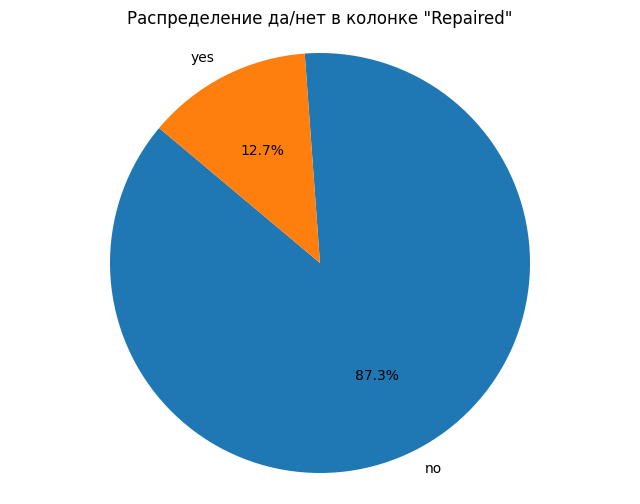

In [26]:
plt.figure(figsize=(8, 6))
plt.pie(repaired_cars_counts, labels=repaired_cars_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение да/нет в колонке "Repaired"')
plt.axis('equal')
plt.show()

учитывая процентное соотношение между "да" и "нет", можно сделать вывод, что пользователи просто проигнорировали вопрос, подразумевая ответ да.

In [27]:
data['Repaired'].fillna('yes', inplace=True)

In [28]:
print(data.isnull().sum())

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        354365 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            354365 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              354365 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           354365 non-null  object
 9   Brand              354365 non-null  object
 10  Repaired           354365 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


Все пропущенные значения заполнены.

Работа с аномалиями:

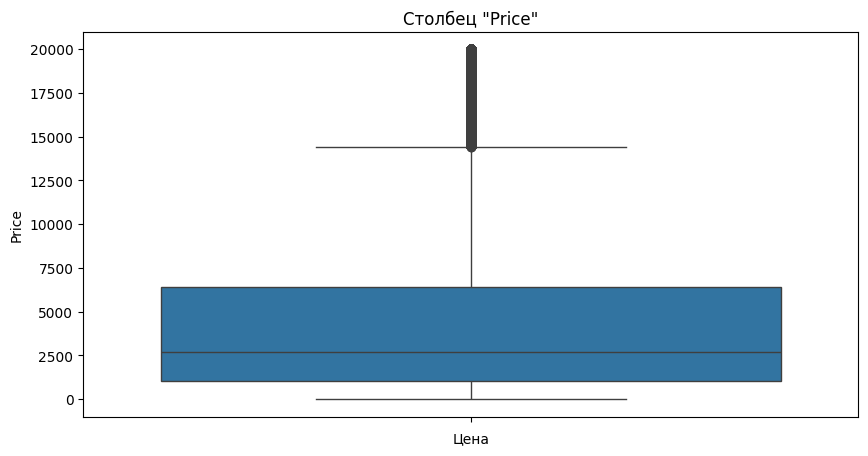

In [30]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data['Price'])
plt.title('Столбец "Price"')
plt.xlabel('Цена')
plt.show()

In [31]:
data = data[data['Price'] <= 15500]

In [32]:
data = data[data['Price'] >= 1000]

In [33]:
print(data.describe())

               Price  RegistrationYear          Power      Kilometer  \
count  257613.000000     257613.000000  257613.000000  257613.000000   
mean     4990.599760       2004.451491     118.250744  127712.498981   
std      3667.274979         54.766956     195.509870   36896.050824   
min      1000.000000       1000.000000       0.000000    5000.000000   
25%      2000.000000       2000.000000      75.000000  125000.000000   
50%      3800.000000       2004.000000     110.000000  150000.000000   
75%      6999.000000       2008.000000     150.000000  150000.000000   
max     15500.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  
count      257613.000000  
mean            6.002174  
std             3.613627  
min             0.000000  
25%             3.000000  
50%             6.000000  
75%             9.000000  
max            12.000000  


Удалим все аномальные значения в цене.

In [34]:
print (data['RegistrationMonth'].unique())

[ 8  6  7 12  2  1  4  5  9 11  0  3 10]


In [35]:
print("Количество строк с месяцем регистрации 0:", (data['RegistrationMonth'] == 0).sum())

Количество строк с месяцем регистрации 0: 17411


In [36]:
data = data[data['RegistrationMonth'] !=0]

Удалим все нулевые значения в месяце регистрации

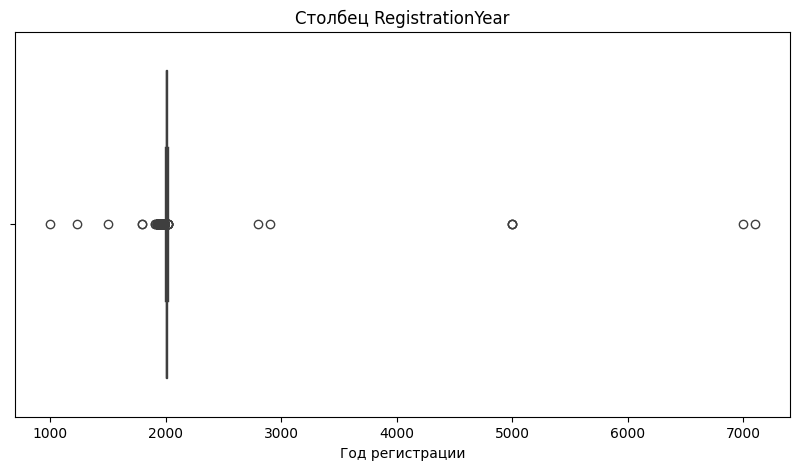

In [37]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='RegistrationYear')
plt.title('Столбец RegistrationYear')
plt.xlabel('Год регистрации')
plt.show()

In [38]:
display (data[data['RegistrationYear'] > 2024])

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
46741,5000,unknown,2900,manual,120,corsa,5000,9,petrol,opel,yes
79903,9000,unknown,5000,manual,420,impreza,5000,6,petrol,subaru,no
255866,1700,unknown,2800,manual,98,unknown,5000,7,petrol,volkswagen,yes
263113,10900,unknown,7000,unknown,0,polo,10000,3,unknown,volkswagen,yes
275090,14800,unknown,5000,auto,0,5er,5000,8,petrol,bmw,yes
308414,4000,unknown,7100,manual,0,panda,10000,3,unknown,fiat,yes
322234,15000,unknown,5000,unknown,155,golf,5000,5,petrol,volkswagen,yes


In [39]:
data = data[data['RegistrationYear'] <= 2020]

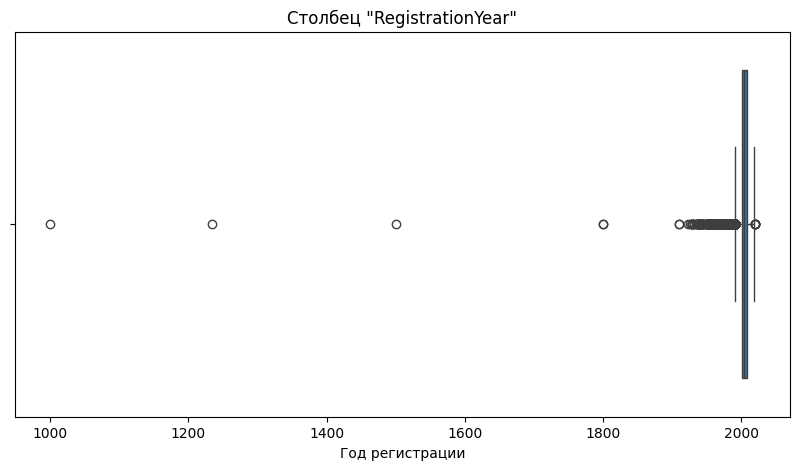

In [40]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='RegistrationYear')
plt.title('Столбец "RegistrationYear"')
plt.xlabel('Год регистрации')
plt.show()

In [41]:
display (data[data['RegistrationYear'] <= 1940])

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
2273,1800,convertible,1925,unknown,0,unknown,5000,1,unknown,sonstige_autos,no
18224,7999,unknown,1500,manual,224,impreza,5000,3,unknown,subaru,yes
22621,14000,sedan,1929,manual,30,unknown,5000,7,petrol,sonstige_autos,yes
26216,15000,small,1940,manual,24,unknown,5000,7,petrol,sonstige_autos,no
29933,12900,sedan,1940,manual,0,unknown,150000,4,petrol,ford,yes
33638,5400,small,1937,manual,0,other,20000,3,petrol,opel,no
34055,2900,small,1937,manual,34,other,40000,7,petrol,ford,yes
37953,9500,other,1937,unknown,0,other,20000,4,unknown,ford,yes
38875,1234,unknown,1234,unknown,26,unknown,5000,1,unknown,trabant,yes
62803,3400,small,1910,manual,90,beetle,90000,4,unknown,volkswagen,no


In [42]:
data = data[data['RegistrationYear'] >= 1940]

In [43]:
data = data[data['RegistrationYear'] <= 2016]

In [44]:
print('Максимальный год регистрации', data['RegistrationYear'].max())

Максимальный год регистрации 2016


Удалили все странные значения из RegistrationYear

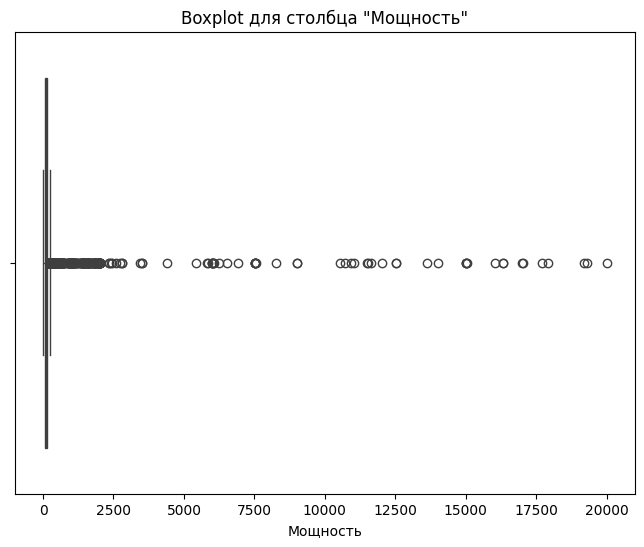

In [45]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Power'])
plt.title('Boxplot для столбца "Мощность"')
plt.xlabel('Мощность')
plt.show()

In [46]:
data=data[(data['Power'] >= 20) & (data['Power'] <= 600)]

Удаление аномальных значений из столбца Power — мощность (л. с.)

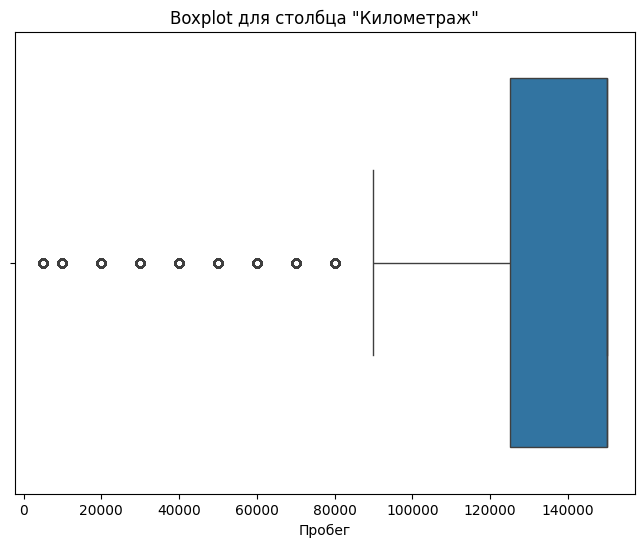

In [47]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Kilometer'])
plt.title('Boxplot для столбца "Километраж"')
plt.xlabel('Пробег')
plt.show()

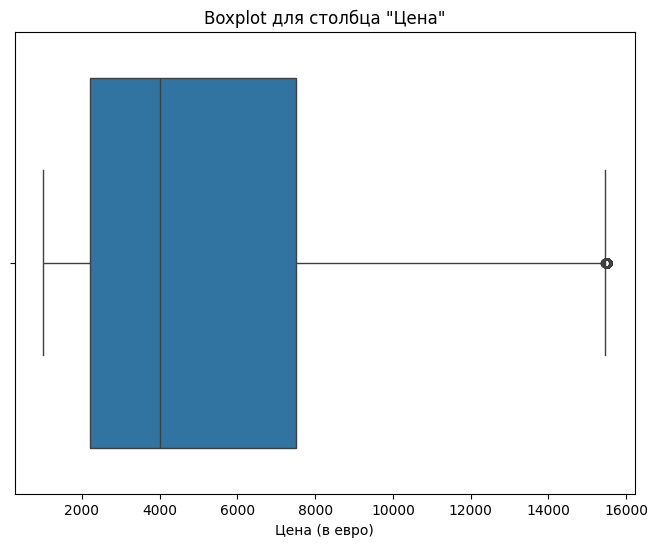

In [48]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Price'])
plt.title('Boxplot для столбца "Цена"')
plt.xlabel('Цена (в евро)')
plt.show()

In [49]:
print ((data['Price'] > 14000).sum())

5815


In [50]:
data = data[data['Price'] <= 14000]

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212396 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              212396 non-null  int64 
 1   VehicleType        212396 non-null  object
 2   RegistrationYear   212396 non-null  int64 
 3   Gearbox            212396 non-null  object
 4   Power              212396 non-null  int64 
 5   Model              212396 non-null  object
 6   Kilometer          212396 non-null  int64 
 7   RegistrationMonth  212396 non-null  int64 
 8   FuelType           212396 non-null  object
 9   Brand              212396 non-null  object
 10  Repaired           212396 non-null  object
dtypes: int64(5), object(6)
memory usage: 19.4+ MB


Работа с аномальными значениями закончена.

In [52]:
print(data['Model'].unique())

['grand' 'golf' 'fabia' '2_reihe' '3_reihe' 'passat' 'twingo' 'c_max'
 'a_klasse' 'scirocco' '5er' 'civic' 'transporter' 'e_klasse' 'other'
 'one' 'fortwo' '1er' 'b_klasse' '3er' 'a8' 'jetta' 'c_klasse' 'micra'
 'vito' 'sprinter' 'forester' 'xc_reihe' 'fiesta' 'scenic' 'focus' 'a4'
 'tt' 'astra' 'a6' 'jazz' 'polo' 'slk' '7er' 'combo' '80' '147' 'unknown'
 'z_reihe' 'sorento' 'ibiza' 'eos' 'touran' 'getz' 'insignia' 'ka'
 'almera' 'megane' 'a3' 'lupo' 'cordoba' 'clio' 'a1' 'berlingo' 'tiguan'
 '6_reihe' 'c4' 'panda' 'up' 'i_reihe' 'ceed' 'yeti' 'octavia' 'zafira'
 'mii' 'rx_reihe' 'corsa' 'punto' 'fox' 'vectra' 'matiz' 'beetle' 'rio'
 'logan' 'spider' 'cuore' 's_max' 'modus' 'a2' 'c3' 'mondeo' 'sharan'
 'avensis' 'viano' 'roomster' 'sl' 'kaefer' 'santa' 'leon' 'cooper'
 '4_reihe' 'sportage' 'caddy' 'ptcruiser' 'clk' 'primera' 's_klasse'
 'galaxy' '159' 'transit' 'juke' 'x_reihe' 'espace' 'carisma' 'accord'
 'corolla' 'phaeton' 'verso' 'swift' 'rav' 'colt' 'picanto' 'boxster'
 'stilo' 'a

In [53]:
model_counts = data['Model'].value_counts()
top_14_models = model_counts.head(14)
print(top_14_models)

golf        17384
other       14279
3er         13443
passat       6739
a4           6680
polo         6516
astra        6254
unknown      5906
5er          5689
c_klasse     5605
corsa        5516
e_klasse     4785
a3           4211
a6           4058
Name: Model, dtype: int64


In [54]:
top_14_models = data['Model'].value_counts().head(14).index
data['Model'] = data['Model'].where(data['Model'].isin(top_14_models), other='other')

In [55]:
print(data['Model'].unique())

['other' 'golf' 'passat' '5er' 'e_klasse' '3er' 'c_klasse' 'a4' 'astra'
 'a6' 'polo' 'unknown' 'a3' 'corsa']


In [56]:
data.drop(columns=['RegistrationMonth'], inplace=True)

In [57]:
print (data.duplicated().sum())

30231


In [58]:
data = data.drop_duplicates()

In [59]:
print (data.duplicated().sum())

0


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182165 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             182165 non-null  int64 
 1   VehicleType       182165 non-null  object
 2   RegistrationYear  182165 non-null  int64 
 3   Gearbox           182165 non-null  object
 4   Power             182165 non-null  int64 
 5   Model             182165 non-null  object
 6   Kilometer         182165 non-null  int64 
 7   FuelType          182165 non-null  object
 8   Brand             182165 non-null  object
 9   Repaired          182165 non-null  object
dtypes: int64(4), object(6)
memory usage: 15.3+ MB


Проведена подготовка данных. Удалены неинформативные признаки, заполнены пропущенные значения, убраны аномальные значения, данные готовы к следующему этапу.

## Обучение моделей

In [61]:
x = data.drop('Price', axis=1)
y = data['Price']

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=123)

In [62]:
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

Линейные модели:

In [63]:
column_transformer_ohe = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)], remainder='passthrough')

Я ставила handle_unknown='error', у меня появлялась такая проблема:

column_transformer_ohe = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(handle_unknown='error'), categorical_features)], remainder='passthrough')

x_train_ohe = column_transformer_ohe.fit_transform(x_train)
x_val_ohe = column_transformer_ohe.transform(x_val)
x_test_ohe = column_transformer_ohe.transform(x_test)

ValueError: Found unknown categories ['elefantino'] in column 2 during transform

Нелинейные модели:

In [64]:
column_transformer_ordinal = ColumnTransformer(transformers=[
    ('ordinal', OrdinalEncoder(), categorical_features)], remainder='passthrough')

In [65]:
x_train_ohe = column_transformer_ohe.fit_transform(x_train)
x_val_ohe = column_transformer_ohe.transform(x_val)
x_test_ohe = column_transformer_ohe.transform(x_test)

In [66]:
x_train_ordinal = column_transformer_ordinal.fit_transform(x_train)
x_val_ordinal = column_transformer_ordinal.transform(x_val)
x_test_ordinal = column_transformer_ordinal.transform(x_test)

сделаю масштабирование числовых признаков

(with_mean=False) из-за проблем с матрицами, использую игнорирование центрирования, чтобы использовать масштабирование.

In [67]:
scaler = StandardScaler(with_mean=False)

In [68]:
x_train_scaled = scaler.fit_transform(x_train_ohe)
x_val_scaled = scaler.transform(x_val_ohe)
x_test_scaled = scaler.transform(x_test_ohe)

In [69]:
def train_model(model, x_train, y_train, x_val, y_val):
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(x_val)
    prediction_time = time.time() - start_time

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse, training_time, prediction_time

Функция принимает данные, обучает модель на тренировочных данных, измеряет время обучения, предсказания, рассчитывает rmse, возвращает все необходимые данные.

In [70]:
linear_model = LinearRegression()
linear_rmse, linear_train_time, linear_predict_time = train_model(linear_model,x_train_scaled,
                                                                               y_train, x_val_scaled, y_val)

print(f'Линейная регрессия RMSE: {linear_rmse:.4f}, '
      f'Время обучения: {linear_train_time:.2f} сек, '
      f'Время предсказания: {linear_predict_time:.2f} сек')

Линейная регрессия RMSE: 2311.5194, Время обучения: 0.48 сек, Время предсказания: 0.00 сек


In [71]:
best_rmse_rf = float('inf')
best_train_time_rf = float('inf')
best_predict_time_rf = float('inf')
for n_estimators in tqdm(range(10, 101, 30)):
    for max_depth in range(3, 12, 3):
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=10, n_jobs=-1, random_state=123)
        rmse, train_time, predict_time = train_model(model, x_train_ordinal, y_train, x_val_ordinal, y_val)
        if rmse < best_rmse_rf:
            best_rmse_rf = rmse
            best_params_rf = {'n_estimators': n_estimators, 'max_depth': max_depth}
            best_train_time_rf, best_predict_time_rf = train_time, predict_time

print(f'Лучший RMSE случайного леса: {best_rmse_rf:.4f} с лучшими параметрами: {best_params_rf}, '
      f'Время обучения: {best_train_time_rf:.2f} сек, Время предсказания: {best_predict_time_rf:.2f} сек')

100%|██████████| 4/4 [00:53<00:00, 13.45s/it]

Лучший RMSE случайного леса: 1681.5808 с лучшими параметрами: {'n_estimators': 100, 'max_depth': 9}, Время обучения: 10.87 сек, Время предсказания: 0.23 сек


In [72]:
best_rmse_lgb = float('inf')
best_train_time_lgb = float('inf')
best_predict_time_lgb = float('inf')

for num_leaves in tqdm(range(20, 51, 10)):
    for learning_rate in [0.01, 0.05, 0.1]:
        model = lgb.LGBMRegressor(num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=100, random_state=123)
        rmse, train_time, predict_time = train_model(model, x_train_ordinal, y_train, x_val_ordinal, y_val)
        if rmse < best_rmse_lgb:
            best_rmse_lgb = rmse
            best_params_lgb = {'num_leaves': num_leaves, 'learning_rate': learning_rate}
            best_train_time_lgb, best_predict_time_lgb = train_time, predict_time

print(f'Лучший RMSE LightGBM: {best_rmse_lgb:.4f} с лучшими параметрами: {best_params_lgb}, '
      f'Время обучения: {best_train_time_lgb:.2f} сек, Время предсказания: {best_predict_time_lgb:.2f} сек')

  0%|          | 0/4 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 109299, number of used features: 9
[LightGBM] [Info] Start training from score 5046.526062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 109299, number of used features: 9
[LightGBM] [Info] Start training from score 5046.526062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train 

 25%|██▌       | 1/4 [00:03<00:11,  3.73s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 109299, number of used features: 9
[LightGBM] [Info] Start training from score 5046.526062
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 109299, number of used features: 9
[LightGBM] [Info] Start training from score 5046.526062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train 

 50%|█████     | 2/4 [00:08<00:08,  4.39s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 109299, number of used features: 9
[LightGBM] [Info] Start training from score 5046.526062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 109299, number of used features: 9
[LightGBM] [Info] Start training from score 5046.526062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 109299, number of used features: 9
[LightGBM] [Info] Start 

 75%|███████▌  | 3/4 [00:13<00:04,  4.44s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 109299, number of used features: 9
[LightGBM] [Info] Start training from score 5046.526062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 109299, number of used features: 9
[LightGBM] [Info] Start training from score 5046.526062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train 

100%|██████████| 4/4 [00:17<00:00,  4.48s/it]

Лучший RMSE LightGBM: 1481.4066 с лучшими параметрами: {'num_leaves': 50, 'learning_rate': 0.1}, Время обучения: 1.29 сек, Время предсказания: 0.34 сек


## Анализ моделей

В прошлом пункте были использованы следующие модели: линейная регрессия, рандомный лес и LightGBM.

Лучший результат RMSE у линейной регрессии: 2311.519

Лучший результат RMSE у Рандомного леса: 1681.5808

Лучший результат RMSE у LightGBM: 1481.4066

Линейная регрессия работает быстрее всех моделей, но ее качество существенно хуже остальных моделей. Максимально оптимизированы модели Рандомного Леса и LGBM.

Критерии, которые важны заказчику:
    
• качество предсказания;

• время обучения модели;

• время предсказания модели.

Линейная регрессия RMSE: 2311.5194, Время обучения: 1.48 сек, Время предсказания: 0.00 сек

Лучший RMSE случайного леса: 1681.5808 с лучшими параметрами: {'n_estimators': 100, 'max_depth': 9}, Время обучения: 8.94 сек, Время предсказания: 0.25 сек

Лучший RMSE LightGBM: 1481.4066 с лучшими параметрами: {'num_leaves': 50, 'learning_rate': 0.1}, Время обучения: 50.60 сек, Время предсказания: 0.30 сек

Из всех моделей выбираем RMSE LightGBM.

In [73]:
best_lgb_model = lgb.LGBMRegressor(num_leaves=best_params_lgb['num_leaves'],
                                   learning_rate=best_params_lgb['learning_rate'],
                                   n_estimators=100,
                                   random_state=123)
best_lgb_model.fit(x_train_ordinal, y_train)
y_test_pred_lgb = best_lgb_model.predict(x_test_ordinal)
rmse_test_lgb = np.sqrt(mean_squared_error(y_test, y_test_pred_lgb))
print(f'RMSE LightGBM на тестовой выборке: {rmse_test_lgb:.4f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 109299, number of used features: 9
[LightGBM] [Info] Start training from score 5046.526062
RMSE LightGBM на тестовой выборке: 1501.6815


В ходе работы выполнены все основные шаги:

1. Загрузите данные, путь к файлу: /datasets/autos.csv.
2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
3. Подготовьте выборки для обучения моделей.
4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
5. Проанализируйте время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Во время подготовки данных:

1. Удалены неинформативные признаки.
2. Обработаны пропущенные значения, заменены на наиболее подходящие.
3. Удалены дубликаты данных.
4. Проведена работа с выбросами и аномальными значениями.

Была проведена предобработка данных: преобразование категориальных признаков в числовые через LabelEncoder, а также масштабирование числовых признаков через StandardScaler. Были использоованы модели линейной регрессии, случайного леса и LightGBM. Найдены лучшие гиперпараметры для каждой модели, качество моделей было оценено с помощью RMSE.

Все полученные результаты меньше 2500, что соответствует задаче. Также были максимально оптимизированы все модели. В итоге, получена лучшая модель и проделаны все необходимые рассчеты.

В последнем тесте на тестовой выборке получен результат RMSE LightGBM: 1501.6815